In [18]:
# 1. Imports & basic setup

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score
)

from catboost import CatBoostClassifier, Pool

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [26]:
# 2. Load dataset

df = pd.read_csv(r"F:\Workspace\Working\college-minor-project\datasets\DatasetofDiabetes.csv")

print("Shape:", df.shape)
display(df.head())

print("\nInfo:")
print(df.info())

print("\nClass distribution:")
print(df["CLASS"].value_counts())


Shape: (1000, 14)


,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB
None

Class distribution:
CLASS
Y    844
N    103
P     53
Name: count, dtype: int64


3. Preprocessing

In [27]:
df_proc = df.copy()

# 3.1 Drop ID-like columns (adjust if your names differ)
id_cols = [col for col in df_proc.columns if col.lower() in ["id", "no_of_patient", "no_patient", "patient_no", "patient_id", "no_pation"]]
print("Dropping ID-like columns:", id_cols)
df_proc = df_proc.drop(columns=id_cols)

Dropping ID-like columns: ['ID', 'No_Pation']


In [28]:
# 3.2 Standardize / encode Gender
# Assumes values like 'Male'/'Female' or 'M'/'F'
if "Gender" in df_proc.columns:
    df_proc["Gender"] = df_proc["Gender"].astype(str).str.strip().str.lower()
    df_proc["Gender"] = df_proc["Gender"].replace({
        "male": 1, "m": 1,
        "female": 0, "f": 0
    })
else:
    print("WARNING: 'Gender' column not found. Adjust preprocessing if necessary.")

C:\Users\PC\AppData\Local\Temp\ipykernel_16684\1914179091.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_proc["Gender"] = df_proc["Gender"].replace({


In [31]:
# 3.3 Treat physiologically impossible zeros as missing (NaN)
# Adjust these names to match your CSV exactly
zero_as_missing_cols = [
    "HbA1c",
    "Cr",
    "BMI",
    "Urea",
    "Chol",
    "LDL",
    "VLDL",
    "TG",
    "HDL"
]

for col in zero_as_missing_cols:
    if col in df_proc.columns:
        # Only replace zeros if there are any
        n_zeros = (df_proc[col] == 0).sum()
        if n_zeros > 0:
            print(f"Replacing {n_zeros} zeros with NaN in column '{col}'")
            df_proc.loc[df_proc[col] == 0, col] = np.nan
    else:
        print(f"Column '{col}' not found in dataframe (OK if naming differs).")

In [33]:
# 3.4 Separate features & target
target_col = "CLASS"
assert target_col in df_proc.columns, f"Target column '{target_col}' not found!"

In [34]:

X = df_proc.drop(columns=[target_col])
y_raw = df_proc[target_col]

# Encode class labels to integers for metrics
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

print("\nEncoded classes:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("X shape:", X.shape, "y shape:", y.shape)

# Check missing values
print("\nMissing values per column:")
print(X.isna().sum())



Encoded classes: {'N': np.int64(0), 'P': np.int64(1), 'Y': np.int64(2)}
X shape: (1000, 11) y shape: (1000,)

Missing values per column:
Gender    0
AGE       0
Urea      0
Cr        0
HbA1c     0
Chol      0
TG        0
HDL       0
LDL       0
VLDL      0
BMI       0
dtype: int64


In [35]:
# 4. Train / validation / test split

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train+Val shape:", X_train_full.shape, "Test shape:", X_test.shape)

# Optionally, we can later do K-fold CV on X_train_full, y_train_full


Train+Val shape: (800, 11) Test shape: (200, 11)


In [36]:
# 5. CatBoost parameters (good strong baseline for multiclass)

N_CLASSES = len(np.unique(y))

CATBOOST_PARAMS = {
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "learning_rate": 0.03,
    "depth": 5,
    "l2_leaf_reg": 3.0,
    "random_seed": RANDOM_STATE,
    "iterations": 3000,        # we'll rely on early stopping
    "od_type": "Iter",
    "od_wait": 100,            # early stopping rounds
    "thread_count": -1,
    "verbose": 100,
    "bootstrap_type": "Bayesian",
    "bagging_temperature": 0.5
}


In [37]:
# 6. Stratified K-Fold cross-validation (optional but recommended)

N_SPLITS = 5

skf = StratifiedKFold(
    n_splits=N_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE
)

fold_metrics = []

fold_idx = 1

for train_idx, val_idx in skf.split(X_train_full, y_train_full):
    print(f"\n========== Fold {fold_idx} / {N_SPLITS} ==========")
    
    X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
    y_tr, y_va = y_train_full[train_idx], y_train_full[val_idx]
    
    # Identify categorical features indices for CatBoost (Gender + any others that are not purely numeric)
    cat_features = [i for i, col in enumerate(X_tr.columns) if X_tr[col].dtype == "object" or col.lower() == "gender"]
    
    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    valid_pool = Pool(X_va, y_va, cat_features=cat_features)
    
    model_cv = CatBoostClassifier(**CATBOOST_PARAMS)
    model_cv.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    
    # Predictions
    y_va_pred = model_cv.predict(valid_pool)
    y_va_pred = y_va_pred.flatten().astype(int)
    
    acc = accuracy_score(y_va, y_va_pred)
    f1_macro = f1_score(y_va, y_va_pred, average="macro")
    
    print(f"Fold {fold_idx} Accuracy: {acc:.4f}, Macro-F1: {f1_macro:.4f}")
    
    fold_metrics.append({"fold": fold_idx, "accuracy": acc, "f1_macro": f1_macro})
    fold_idx += 1

cv_df = pd.DataFrame(fold_metrics)
print("\n===== CV Summary =====")
display(cv_df)
print("Mean accuracy:", cv_df["accuracy"].mean().round(4), "±", cv_df["accuracy"].std().round(4))
print("Mean macro F1:", cv_df["f1_macro"].mean().round(4), "±", cv_df["f1_macro"].std().round(4))



========== Fold 1 / 5 ==========
0:	learn: 1.0553646	test: 1.0564781	best: 1.0564781 (0)	total: 59.6ms	remaining: 2m 58s
100:	learn: 0.1304823	test: 0.1378496	best: 0.1378496 (100)	total: 165ms	remaining: 4.72s
200:	learn: 0.0509035	test: 0.0687182	best: 0.0687182 (200)	total: 264ms	remaining: 3.67s
300:	learn: 0.0275589	test: 0.0510402	best: 0.0510402 (300)	total: 363ms	remaining: 3.25s
400:	learn: 0.0191887	test: 0.0455358	best: 0.0455358 (400)	total: 462ms	remaining: 2.99s
500:	learn: 0.0145525	test: 0.0427204	best: 0.0425252 (478)	total: 565ms	remaining: 2.82s
600:	learn: 0.0116518	test: 0.0409245	best: 0.0408974 (599)	total: 671ms	remaining: 2.68s
700:	learn: 0.0096660	test: 0.0398601	best: 0.0398601 (700)	total: 777ms	remaining: 2.55s
800:	learn: 0.0083919	test: 0.0390477	best: 0.0389580 (787)	total: 878ms	remaining: 2.41s
900:	learn: 0.0073795	test: 0.0387232	best: 0.0386982 (897)	total: 976ms	remaining: 2.27s
1000:	learn: 0.0065401	test: 0.0383218	best: 0.0383076 (977)	total: 

,fold,accuracy,f1_macro
0,1,0.98125,0.966007
1,2,0.98125,0.969228
2,3,1.00000,1.000000
3,4,0.98750,0.977905
4,5,1.00000,1.000000


Mean accuracy: 0.99 ± 0.0095
Mean macro F1: 0.9826 ± 0.0164


In [38]:
# 7. Final training on full train+val and evaluation on test

# Categorical features (reuse logic)
cat_features = [i for i, col in enumerate(X_train_full.columns) if X_train_full[col].dtype == "object" or col.lower() == "gender"]

train_pool_full = Pool(X_train_full, y_train_full, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

final_model = CatBoostClassifier(**CATBOOST_PARAMS)
final_model.fit(train_pool_full, eval_set=test_pool, use_best_model=True)

# Predictions on test
y_test_pred = final_model.predict(test_pool).flatten().astype(int)
y_test_proba = final_model.predict_proba(test_pool)  # shape: [n_samples, n_classes]

acc = accuracy_score(y_test, y_test_pred)
f1_macro = f1_score(y_test, y_test_pred, average="macro")

# For multiclass ROC-AUC, use 'ovr' or 'ovo'
try:
    roc_auc = roc_auc_score(y_test, y_test_proba, multi_class="ovr")
except Exception as e:
    print("ROC-AUC could not be computed:", e)
    roc_auc = None

print("\n===== Test results (CatBoost, multiclass) =====")
print("Accuracy:", round(acc, 4))
print("Macro F1:", round(f1_macro, 4))
if roc_auc is not None:
    print("ROC-AUC (ovr):", round(roc_auc, 4))

print("\nClassification report (labels are encoded classes):")
print(classification_report(y_test, y_test_pred, digits=4))

# Mapping back to original class labels
print("\nLabel mapping (encoded -> original):")
for enc, lab in enumerate(label_encoder.classes_):
    print(f"  {enc} -> {lab}")


0:	learn: 1.0540668	test: 1.0534612	best: 1.0534612 (0)	total: 1.73ms	remaining: 5.19s
100:	learn: 0.1173307	test: 0.1148700	best: 0.1148700 (100)	total: 112ms	remaining: 3.2s
200:	learn: 0.0473067	test: 0.0543881	best: 0.0543881 (200)	total: 226ms	remaining: 3.15s
300:	learn: 0.0266090	test: 0.0417650	best: 0.0417650 (300)	total: 346ms	remaining: 3.1s
400:	learn: 0.0180247	test: 0.0368594	best: 0.0368594 (400)	total: 459ms	remaining: 2.97s
500:	learn: 0.0134641	test: 0.0347632	best: 0.0347632 (500)	total: 567ms	remaining: 2.83s
600:	learn: 0.0109451	test: 0.0336608	best: 0.0336608 (600)	total: 678ms	remaining: 2.7s
700:	learn: 0.0090927	test: 0.0327756	best: 0.0327756 (700)	total: 786ms	remaining: 2.58s
800:	learn: 0.0076285	test: 0.0323051	best: 0.0322606 (796)	total: 899ms	remaining: 2.47s
900:	learn: 0.0066343	test: 0.0321871	best: 0.0321710 (899)	total: 1.01s	remaining: 2.36s
1000:	learn: 0.0058077	test: 0.0322638	best: 0.0319807 (942)	total: 1.13s	remaining: 2.26s
Stopped by over

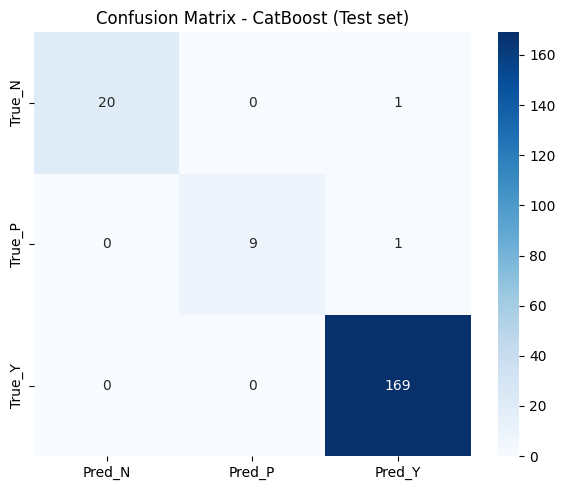

In [39]:
# 8. Confusion matrix

cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"True_{c}" for c in label_encoder.classes_],
    columns=[f"Pred_{c}" for c in label_encoder.classes_]
)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - CatBoost (Test set)")
plt.tight_layout()
plt.show()



Feature importances:


,feature,importance
4,HbA1c,49.160607
10,BMI,19.432617
1,AGE,9.790684
5,Chol,9.644902
6,TG,3.857301
8,LDL,1.946518
9,VLDL,1.688876
2,Urea,1.416063
7,HDL,1.325891
3,Cr,0.941203


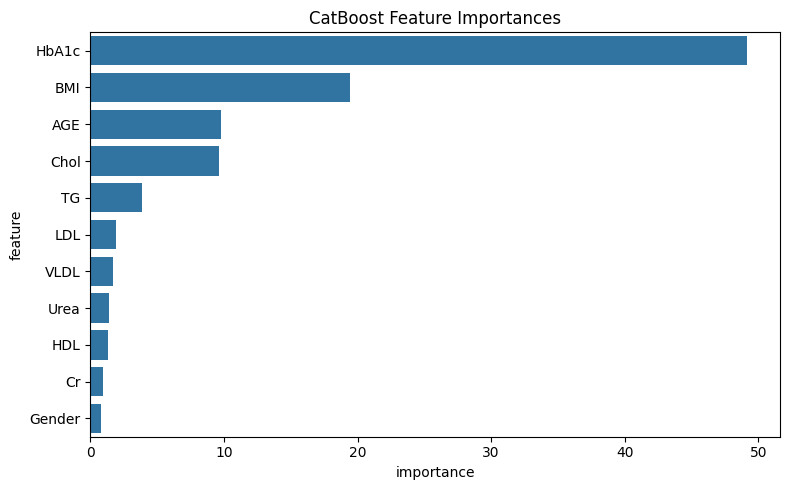

In [40]:
# 9. Feature importance

importances = final_model.get_feature_importance(train_pool_full)
feat_imp_df = pd.DataFrame({
    "feature": X_train_full.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\nFeature importances:")
display(feat_imp_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=feat_imp_df, x="importance", y="feature")
plt.title("CatBoost Feature Importances")
plt.tight_layout()
plt.show()


In [41]:
# 10. Save model & label encoder (optional)

import joblib

joblib.dump(final_model, "catboost_diabetes_multiclass_model.pkl")
joblib.dump(label_encoder, "catboost_diabetes_label_encoder.pkl")

print("Saved model and label encoder to disk.")


Saved model and label encoder to disk.
